In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [168]:
def get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr):
    species_df = state_df[state_df['Species_id'] == species_id]
    species_df = species_df[species_df['Year'] == year]
    species_df = species_df[species_df[attr] >= 0]
    pcts = []
    for week in range(48):
        species_df_week = species_df[species_df['Week'] == week]
        N = len(species_df_week)
        if N == 0:
            pcts.append(0)
        else:
            species_df_week_observed = species_df_week[species_df_week[attr] > 0]
            pcts.append(len(species_df_week_observed) / N)
    return pcts

In [169]:
def num_observations(state_df, year, week, species_id, attr):
    species_df = state_df[state_df['Species_id'] == species_id]
    species_df = species_df[species_df['Year'] == year]
    species_df = species_df[species_df[attr] >= 0]
    species_df_week = species_df[species_df['Week'] == week]
    return len(species_df_week)

In [204]:
def get_scores(state_df, species_id, attr, L=5, M=3, w_1=1, w_2=1):
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores = []
    for week in range(L, len(pcts)-M-1, 1): # todo - calculate score for weeks before week L
        #print(pcts[week-L:week+1])
        try:
            stagn = 1 / (max(pcts[week-L:week+1]) - min(pcts[week-L:week+1]))
        except ZeroDivisionError:
            print(f'Warning: zero division error due to pcts of {pcts[week-L:week+1]} in weeks {week-L} to {week+1}')
            stagn = 10 # sus
        differences_arr = np.array([pcts[k + 1] - pcts[k] for k in range(week, week+M+1, 1)])
        spike = np.sum(np.exp(differences_arr))
        #N = num_observations(state_df, year, week, species_id, attr)
        scores.append(w_1 * (stagn ** 3) + w_2 * spike)
    return scores

In [202]:
def plot_score_and_pcts(species_id, attr, L=5, M=3, w_1=1, w_2=1):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)
    #probs = scores / np.sum(scores)

    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M+1)])
    
    #print(scores)
    print(f"len scores {len(scores)}, len pcts {len(pcts)}")
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))
    
    fig, ax = plt.subplots()
    ax.plot(range(len(pcts)), pcts, label='pct')
    for ex in expected_values:
        ax.axvline(x=ex, color='r', linestyle='--', linewidth=2)
    twin = ax.twinx()
    twin.bar(range(len(pcts)), scores, label='score', alpha=0.25)
    #twin.set_ylim(0, 100)
    plt.title(f"{year}, {species_id}, {attr} probs / pcts, L={L}, M={M}, w_1={w_1}, w_2={w_2}")
    plt.legend()
    plt.show()

len scores 288, len pcts 288


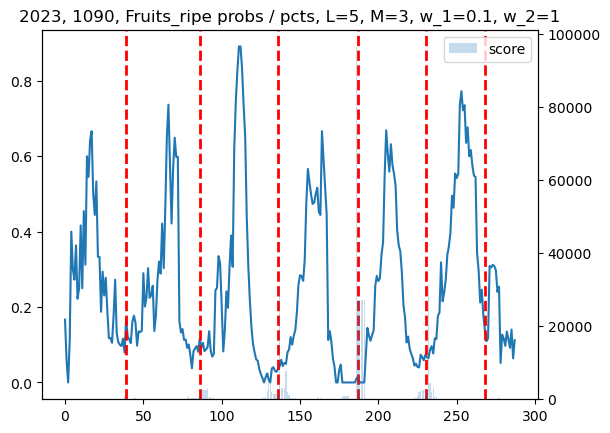

len scores 288, len pcts 288


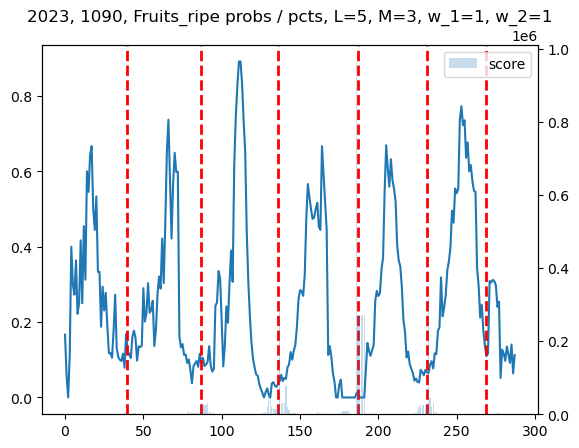

len scores 288, len pcts 288


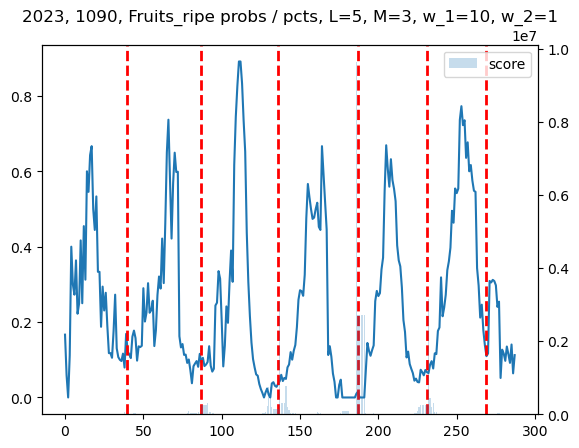

len scores 288, len pcts 288


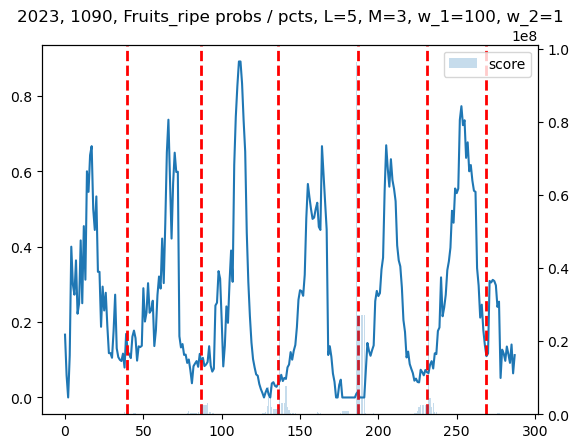

len scores 288, len pcts 288


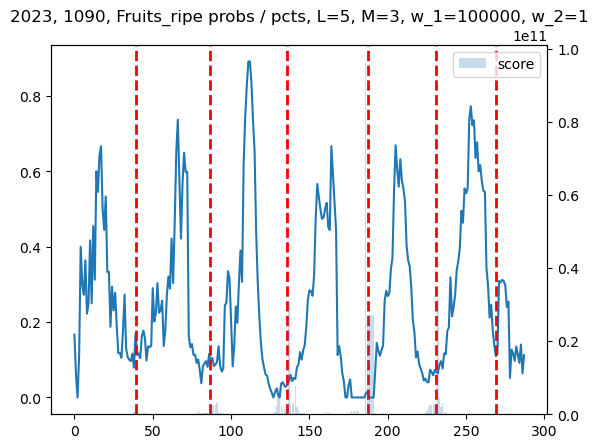

In [205]:
# looks great except for 2023!
for w_1 in [0.1, 1, 10, 100, 100000]:
    for species_id in [1090]:
        for attr in ['Fruits_ripe']:
            plot_score_and_pcts(species_id, attr, L=5, w_1=w_1, w_2=1)

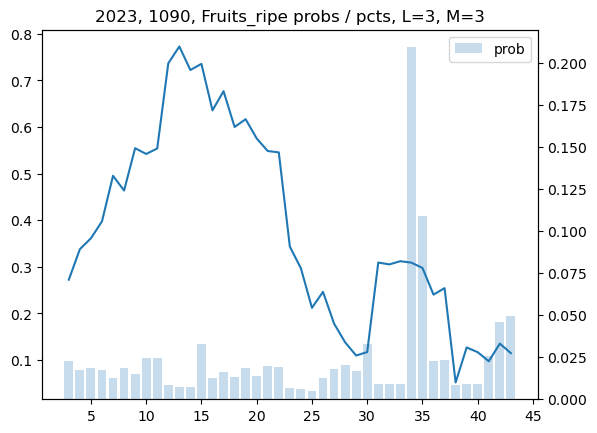

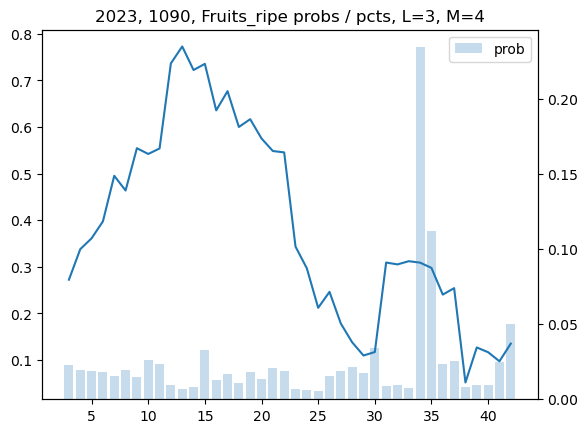

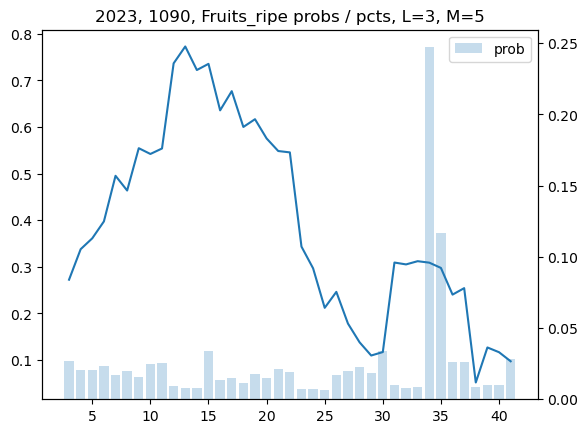

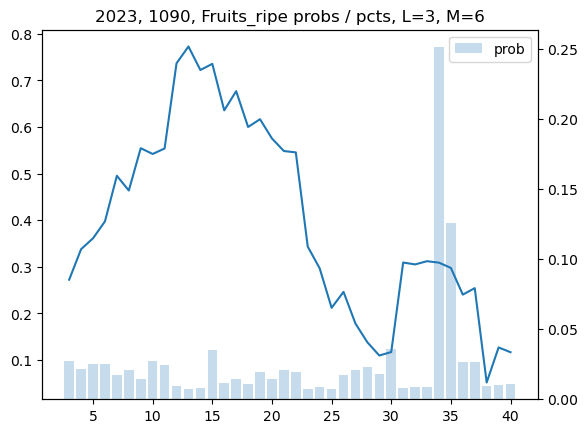

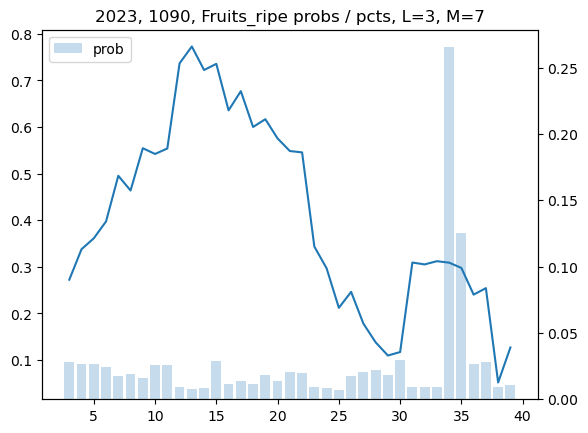

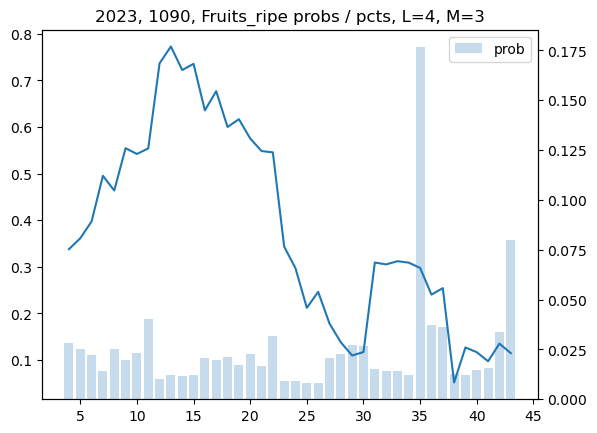

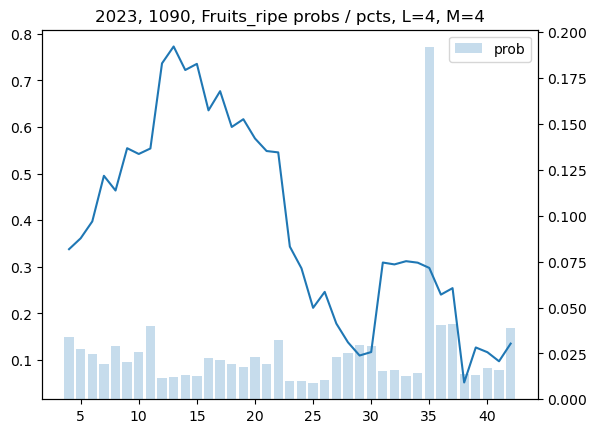

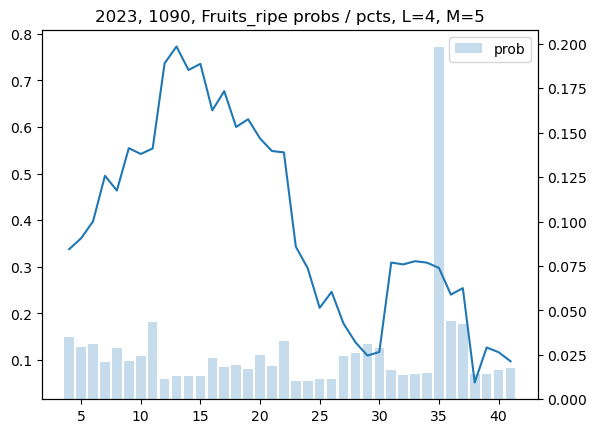

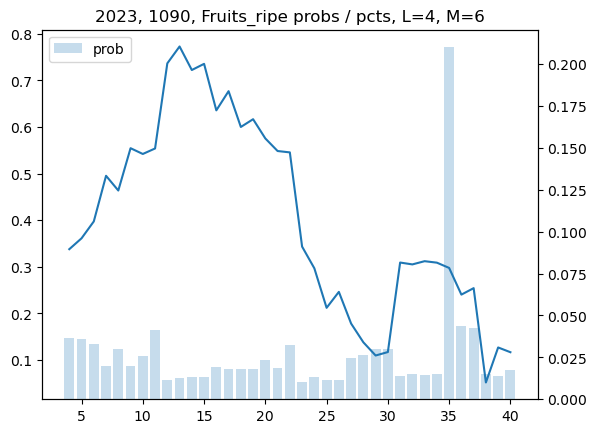

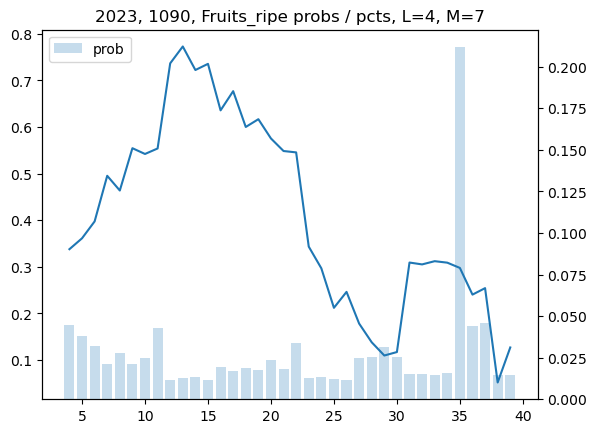

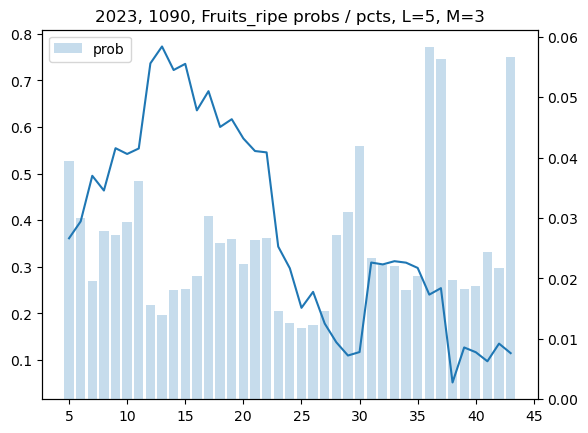

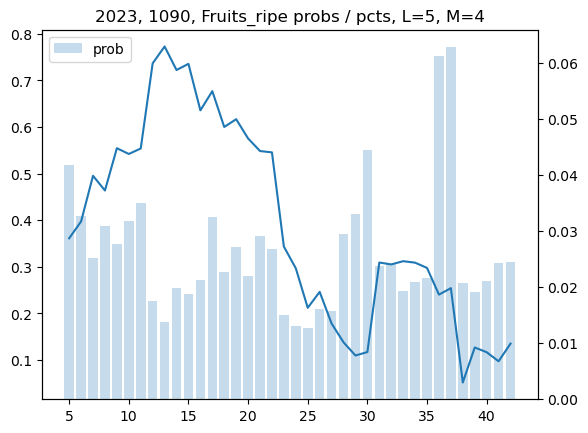

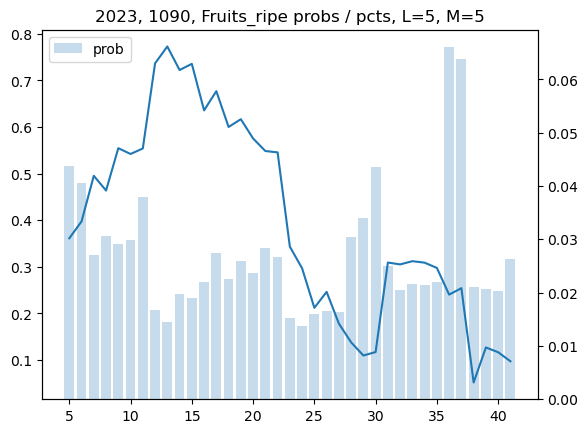

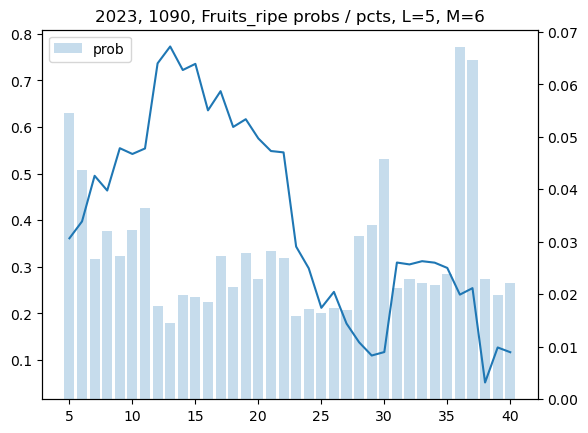

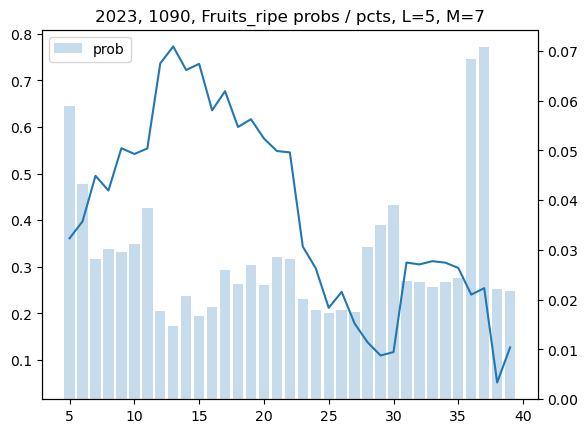

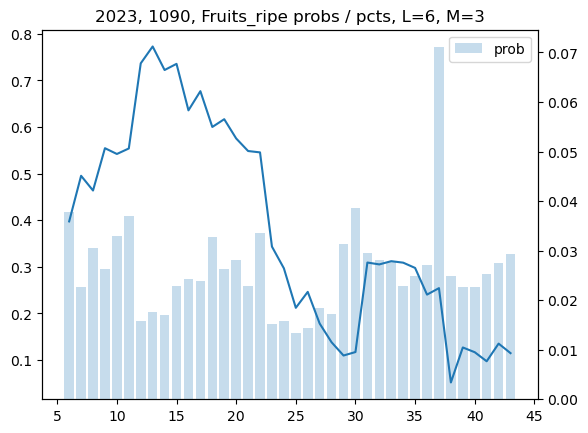

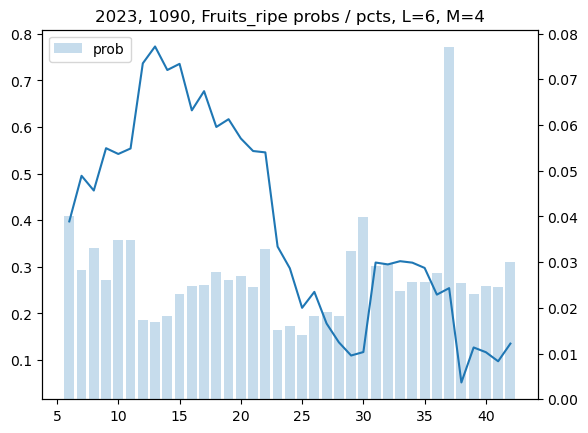

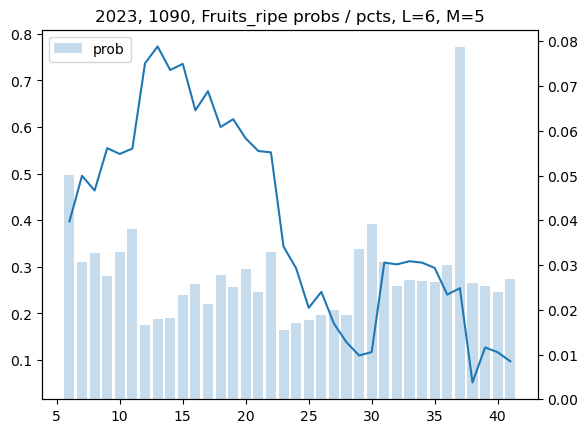

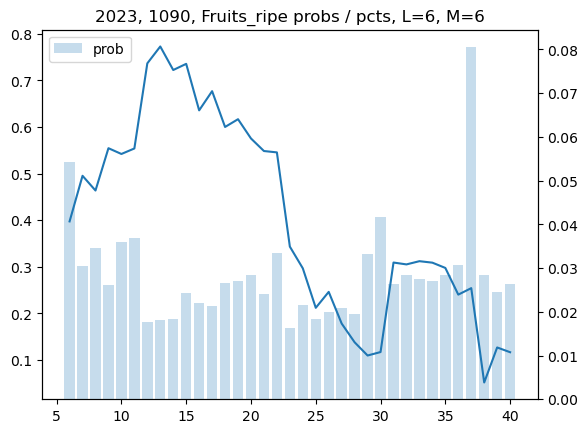

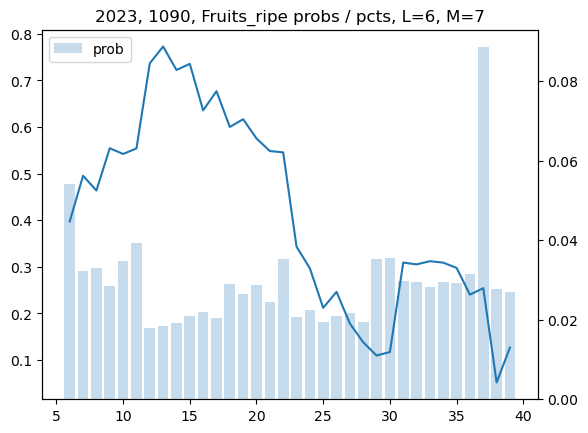

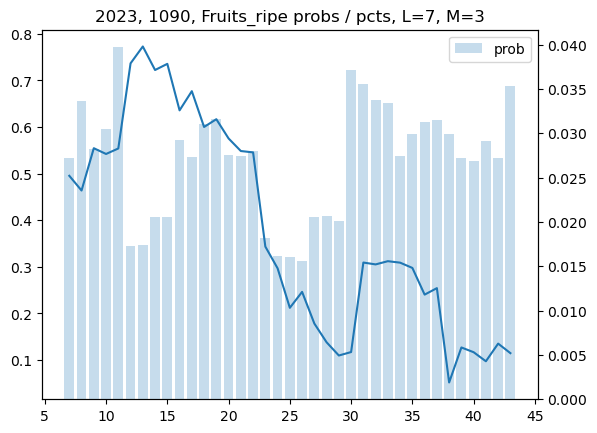

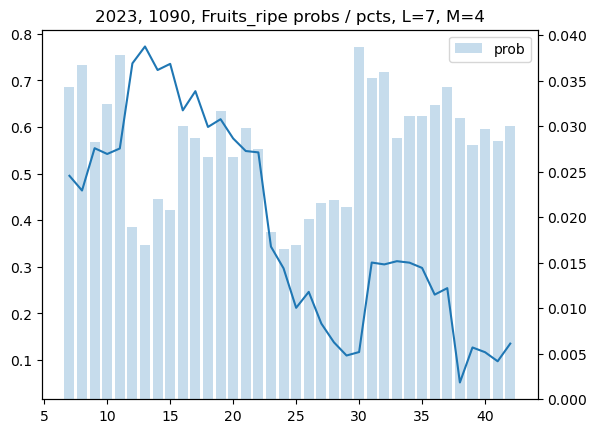

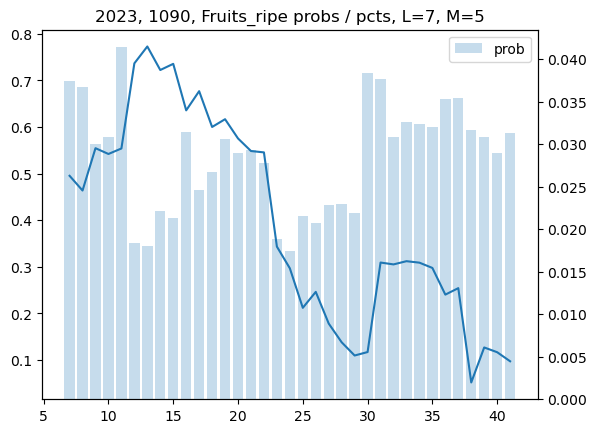

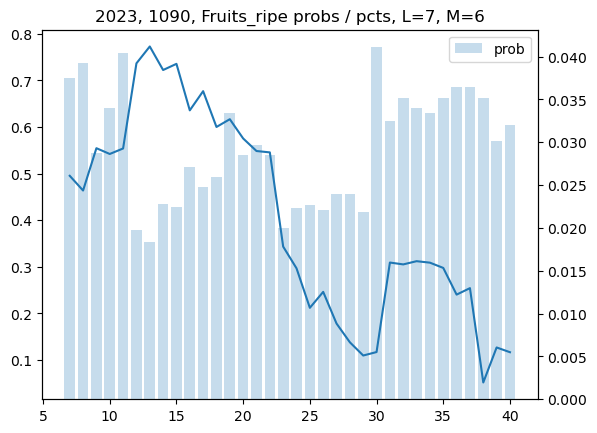

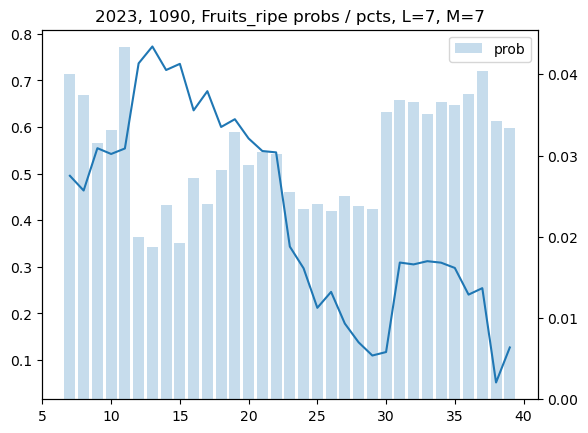

In [107]:
year = 2023
species_id = 1090
attr = 'Fruits_ripe'
for L in range(3, 8):
    for M in range(3, 8):
        plot_score_and_pcts(year, species_id, attr, L=L, M=M)